In [1]:
# Input file  

incode= """
l i1 1 0 n0
mod eo1 9000k .18 1 pm n0 n1 

s s1 1 n1 n4

m PRM 0 1 0 n4 n5 # chosen arbitrarily will optimize it 
s lp 1 n5 n6
bs mainbs 0.5 0.5 0 45 n6  n7 n10 n13
s ly 1 n7 n8 
m1 ETMY 5e-06 3.75e-05 0 n8 n9
s lx 1 n10 n11
m1 ETMX 5e-06 3.75e-05 0 n11 n12
s ls 1 n13 n14


#xaxis lx L lin 0 2.128e-6 1000
xaxis ETMX phi lin 0 360 359

# pd0 PIn n4*
# pd0 AfterPRM n5
# pd0 InBS n6*
# pd0 Outy n7
# pd0 Outx n10

# pd0 iny n7*
# pd0 inx n10*
# pd0 ASDC n14

# pd0 Out n14
# pd0 REFLDC n4
# pd0 LeakX n9
# pd0 LeakY n12
#pd1 REFLI 9000k 0 n4
#pd1 REFLQ 9000k 90 n4
#pd1 ASQ 9000k 90 n14
#pd1 ASI 9000k 90 n14
#pd0 IatPRM n5*
#pd0 IatPRM n5*
#pd1 inphase 9000k 0 n1*
#pd1 quadrature 9000k 90 n1*
yaxis abs
"""

In [2]:
from mpl_toolkits.mplot3d import Axes3D
import pykat

import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib notebook
import numpy as np 
# from numpy import arange
HH=12
WW=7
plt.rcParams.update({'font.size': 15})

                                              ..-
    PyKat 1.1.380         _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



# PRMI
## Configuration 

Degrees of freedom 3
1. DARM (Lx-Ly)
2. CARM (Lx+Ly)
3. Lp (Distance of PRM from the BS)


Variables(3)
1. Reflectivity of PRM
2. Lx-Ly(Asymmetry)
3. LP


Available Demodulated Signals (6)
1. ASQ 
2. ASI
3. REFLQ
4. REFLI
5. POPQ
6. POPI



Approach
1. <b>Find the operating point</b>- point where sensitivity for the DARM is highest.<br> 
In order to locate this point we scan the parameter space by varying all the parameters(Rprm , Lp and Lx-Ly) and monitor the demodulated signals(ASQ REFLQ POPQ etc) with respect to ETMx tuning. We then calculate the derivative of these signals with respect to ETMx tuning and monitor their maximum value. This is how we generate  a 2d graph containing maximum value of the slope(or sensitivity) of the demodulated signals vs the two parameters.


2. <b>Calculate the sensitivities at the Operating point</b> <br>
we first calculate the sensitivity for the unnormalised DOFs<br>
Lx-Ly:  By keeping Ly fixed and tuning the Lx.<br>
Ly-Lx: By keeping Lx fixed and tuning Ly.<br>
we then calculate the sensitivity for DARM and CARM by adding and subtracting the two sensitivities.

![Image not found](config.png "Title")

# Choosing the operating Point
At the operating point the sensitivity of the interferometer for the DARM should be highest.<br>

Trying the initial configuration:<br>
In this configuration the interferometer is at the Balanced point (Lx=Ly) and Power recycling mirror is absent (Rprm=0) 
<br>
The plot of Demodulated signals with respect to tuning of ETMX is shown below . The maximum value of the signal is around 1e-8.

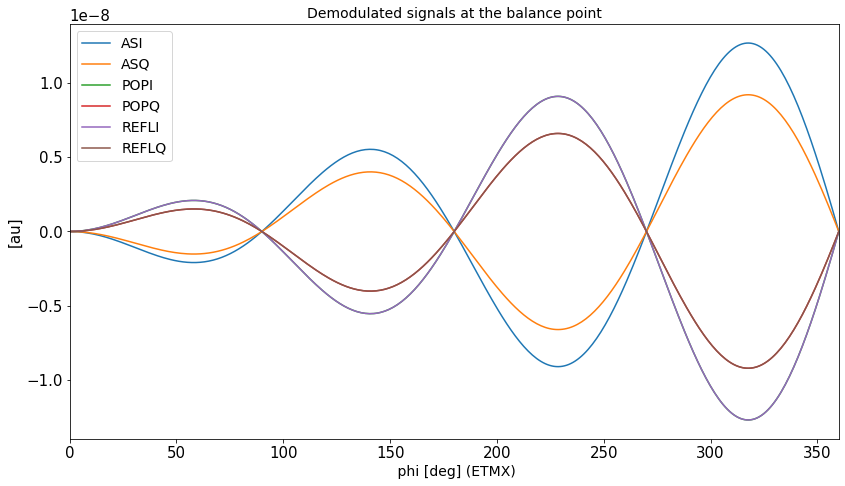

In [3]:
ob = pykat.finesse.kat()
ob.verbose = False
ob.parse(incode)
ob.parse("""pd1 ASQ 9000k 90 n14
pd1 ASI 9000k 0 n14
pd1 POPI 9000k 0 n5*
pd1 POPQ 9000k 90 n5*
pd1 REFLI 9000k 0 n4
pd1 REFLQ 9000k 90 n4
""")
# ob.PRM.R=0
# ob.PRM.T=1-ob.PRM.R
res=ob.run()
plt.rcParams['figure.figsize'] = [HH,WW]
fig = res.plot(title='Demodulated signals at the balance point')

plt.show()

# Optimization :Maximising sensitivity#
## Single variable (Lx-Ly) Optimization 
We have to find other possible states of the interferometer where it is most sensitive for DARM.  
In order to achieve that lets vary the Lx-Ly from 0 to $\lambda_{mod}$ and plot the maximum value of the three demodulated signals(ASQ REFQ POPQ) and see if the value can be maximized.

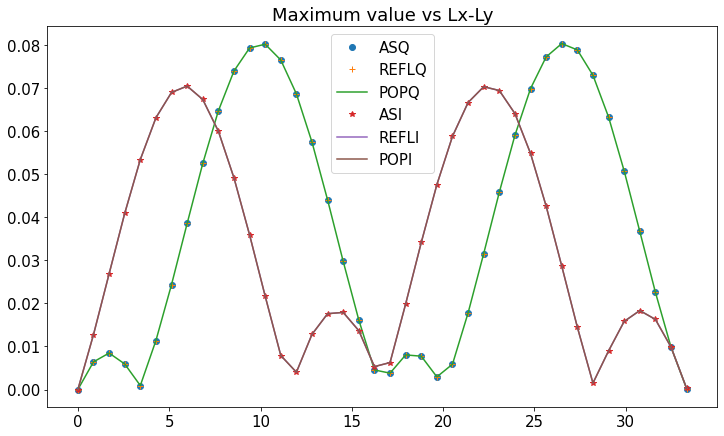

In [4]:
ob = pykat.finesse.kat()
ob.verbose = False
ob.parse(incode)
ob.parse("""pd1 ASQ 9000k 90 n14
pd1 ASI 9000k 0 n14
pd1 POPI 9000k 0 n5*
pd1 POPQ 9000k 90 n5*
pd1 REFLI 9000k 0 n4
pd1 REFLQ 9000k 90 n4
""")

# ob.ly.L=1
# ob.lx.L=1
ob.PRM.R=0
ob.PRM.T=1
n=40

dlmax=33.33
dl=np.zeros(n)
Maxasq=np.zeros(n)
Maxreflq=np.zeros(n)
Maxpopq=np.zeros(n)

Maxasi=np.zeros(n)
Maxrefli=np.zeros(n)
Maxpopi=np.zeros(n)

for i in range(n):
    dli=i*((dlmax)/(n-1))
    ob.lx.L=dli+1
#     print(ob.lx.L)
    res=ob.run()
    dl[i]=dli
    Maxasq[i]=max(res["ASQ"])
    Maxreflq[i]=max(res["REFLQ"])
    Maxpopq[i]=max(res["POPQ"])
    Maxasi[i]=max(res["ASI"])
    Maxrefli[i]=max(res["REFLI"])
    Maxpopi[i]=max(res["POPI"])
    



plt.plot(dl,Maxasq,'o',label='ASQ' )
plt.plot(dl,Maxreflq,'+',label='REFLQ')
plt.plot(dl,Maxpopq,'-',label='POPQ')
plt.plot(dl,Maxasi,'*',label='ASI')
plt.plot(dl, Maxrefli,label='REFLI')
plt.plot(dl, Maxpopi,label='POPI')


plt.legend()
plt.title("Maximum value vs Lx-Ly")
plt.rcParams['figure.figsize'] = [HH,WW]
plt.show()


In this plot we see that:<br> 
1. The In-phase signals(ASI, REFLI, POPI) have the maximum value of about 0.07 at Lx-Ly=6.2.
2. The Quadrature signals(ASQ, REFLQ, POPQ) have the maximum value of about 0.08 at at Lx-Ly=10.2.

Choosing this value of Lx-Ly=10.24 and plotting the Quadrature signals with ETMX tuning.  

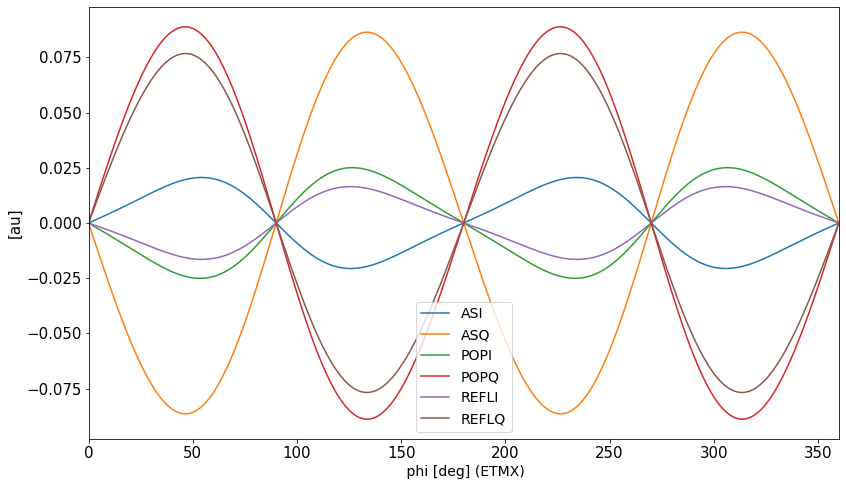

In [5]:
ob = pykat.finesse.kat()
ob.verbose = False
ob.parse(incode)
ob.parse("""pd1 ASQ 9000k 90 n14
pd1 ASI 9000k 0 n14
pd1 POPI 9000k 0 n5*
pd1 POPQ 9000k 90 n5*
pd1 REFLI 9000k 0 n4
pd1 REFLQ 9000k 90 n4
""")


ob.ly.L=1
ob.lx.L=11.203061224489796
ob.PRM.R=0.01
ob.PRM.T=1-ob.PRM.R
res=ob.run()
fig = res.plot()
plt.rcParams['figure.figsize'] = [HH,WW]
plt.show()

# Two variable(Lx-Ly, Rprm) optimization# 
In order to optimize fully we have to vary both variables(Rprm and Lx-Ly) simultaneously. We vary Rprm from 0 to 1 and Lx-Ly 0 to 𝜆𝑚𝑜𝑑 and monitor the maximum value of the sensitivity of demodulated signals.


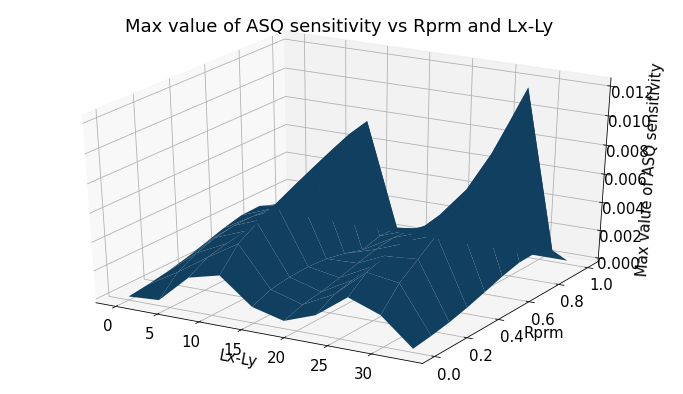

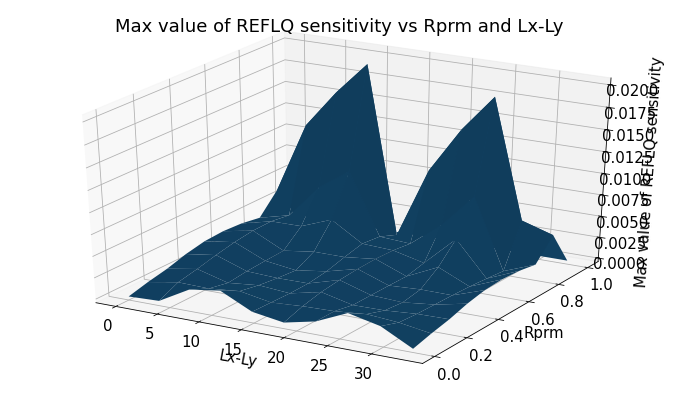

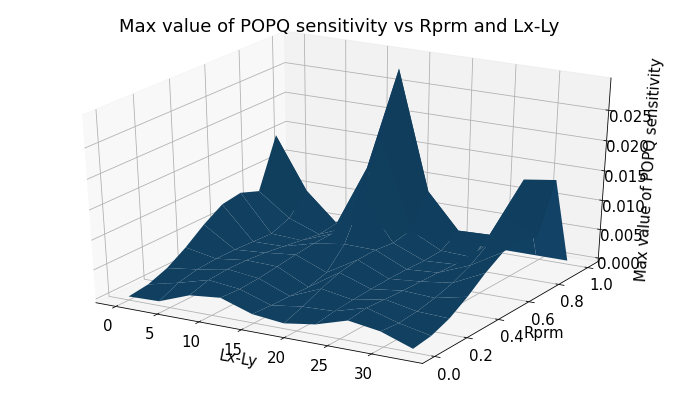

In [6]:

ob = pykat.finesse.kat()
ob.verbose = False
ob.parse(incode)
ob.parse("""pd1 ASQ 9000k 90 n14
pd1 ASI 9000k 0 n14
pd1 POPI 9000k 0 n5*
pd1 POPQ 9000k 90 n5*
pd1 REFLI 9000k 0 n4
pd1 REFLQ 9000k 90 n4
""")

# ob.ly.L=1
# ob.lx.L=1
n=10
dlmax=33.33
rmax=1
dl=np.zeros(n)
ref=np.linspace(0,rmax,n)
dl=np.linspace(0,dlmax,n)

REFLECTIVITY, DL = np.meshgrid(ref,dl)



Maxasq=np.zeros((n,n))
Maxreflq=np.zeros((n,n))
Maxpopq=np.zeros((n,n))
for j in range(n):
    for i in range(n):
        dli=i*((dlmax)/(n-1))
        r=j*((rmax)/(n-1))
        ob.PRM.R=r
        ob.PRM.T=1-r
        ob.lx.L=dli+1
    #     print(ob.lx.L)
        res=ob.run()
        dl[i]=dli
        Maxasq[i][j]=max(np.diff(res["ASQ"]))
        Maxreflq[i][j]=max(np.diff(res["REFLQ"]))
        Maxpopq[i][j]=max(np.diff(res["POPQ"]))
    
# print(len(dl))
# print(len(Maxasq))
# print(dl)


fig = plt.figure()
ax = fig.gca(projection='3d')
plt.title('Max value of ASQ sensitivity vs Rprm and Lx-Ly ')
surf = ax.plot_surface(DL,REFLECTIVITY,Maxasq)
ax.set_xlabel('Lx-Ly')
ax.set_ylabel('Rprm')
ax.set_zlabel('Max value of ASQ sensitivity')
plt.rcParams['figure.figsize'] = [HH,WW]
plt.show()

fig = plt.figure()
ax = fig.gca(projection='3d')
plt.title('Max value of REFLQ sensitivity vs Rprm and Lx-Ly ')
surf = ax.plot_surface(DL,REFLECTIVITY,Maxreflq)
ax.set_xlabel('Lx-Ly')
ax.set_ylabel('Rprm')
ax.set_zlabel('Max value of REFLQ sensitivity ')
plt.rcParams['figure.figsize'] = [HH,WW]
plt.show()


fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(DL,REFLECTIVITY,Maxpopq)
plt.title('Max value of POPQ sensitivity vs Rprm and Lx-Ly ')
ax.set_xlabel('Lx-Ly')
ax.set_ylabel('Rprm')
ax.set_zlabel('Max value of POPQ sensitivity')
plt.rcParams['figure.figsize'] = [HH,WW]
plt.show()


As can be seen from the graph. Maximum values of the sensitivity for different signals are given below<br> 

ASQ has maximum value of 0.12 at Lx-Ly=12.1(also at 29.6)  and R=0.89<br>
REFLQ has maximum value of 0.019 at Lx-Ly=11   and R=0.89<br>
POPQ has maximum value of at 0.35 Lx-Ly=14.76 and R=0.89<br>
<I> Zooming in the region by making the grid fine, reveals that the maximum sensitivity of POPQ occurs at (Lx-Ly=13.76 and R=0.9915)</I>
  


The maximum value of the sensitivity first increases with r and then decreases with r. There is an optimum value of r for which the sensitivity is maximum.

## Three variable(Lx-Ly,Lp Rprm) optimization

In order to optimize fully we have to vary all the variables(Lx-Ly,Lp and Rprm) simultaneously. We vary Rprm from 0 to 1, Lx-Ly and Lp from 0 to 𝜆𝑚𝑜𝑑 and monitor the maximum value of the sensitivity of demodulated signals.


r 0.0
r 0.1111111111111111
r 0.2222222222222222
r 0.3333333333333333
r 0.4444444444444444
r 0.5555555555555556
r 0.6666666666666666
r 0.7777777777777777
r 0.8888888888888888
r 1.0
[33.33]
[0.88888889]
[14.81333333]
Max sensitivity of POPQ is = 0.289517965800554 at Lx-Ly= [33.33] Rprm= [0.88888889] Lp= [14.81333333]


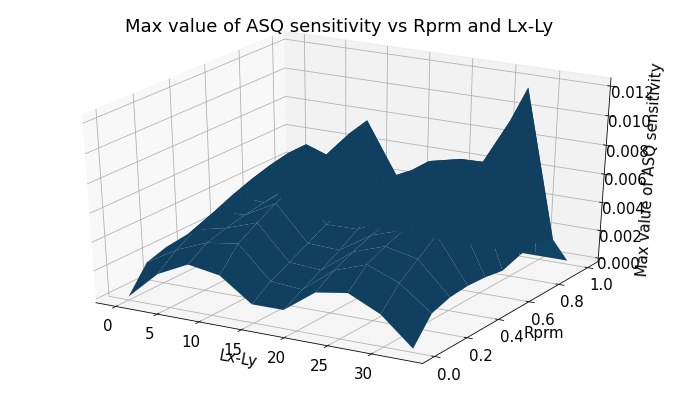

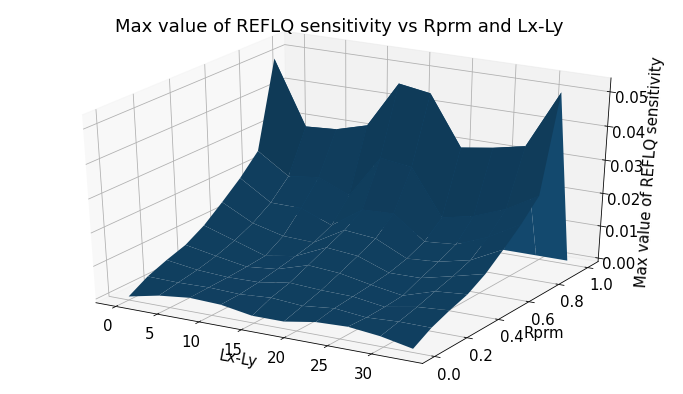

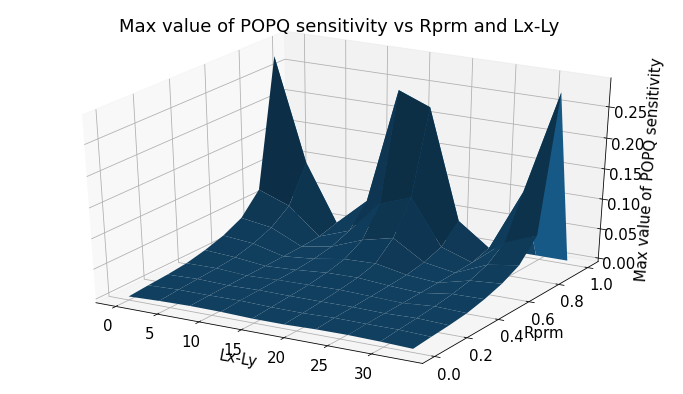

In [7]:
ob = pykat.finesse.kat()
ob.verbose = False
ob.parse(incode)
ob.parse("""pd1 ASQ 9000k 90 n14
pd1 ASI 9000k 0 n14
pd1 POPI 9000k 0 n5*
pd1 POPQ 9000k 90 n5*
pd1 REFLI 9000k 0 n4
pd1 REFLQ 9000k 90 n4
""")

# ob.ly.L=1
# ob.lx.L=1
n=10
dlmax=33.33
rmax=1
dl=np.zeros(n)
ref=np.linspace(0,rmax,n)
dl=np.linspace(0,dlmax,n)

REFLECTIVITY, DL = np.meshgrid(ref,dl)



Maxasq=np.zeros((n,n,n))
Maxreflq=np.zeros((n,n,n))
Maxpopq=np.zeros((n,n,n))
maxasq2=np.zeros((n,n))
maxreflq2=np.zeros((n,n))
maxpopq2=np.zeros((n,n))


for j in range(n):
    r=j*((rmax)/(n-1))
    ob.PRM.R=r
    ob.PRM.T=1-r
    print("r",r)
    for i in range(n):
        dli=i*((dlmax)/(n-1))
        ob.lx.L=dli+1
    #     print(ob.lx.L)
        

        for p in range(n):
            dlp=p*((dlmax)/(n-1))
            ob.lp.L=dlp+1
            res=ob.run()
        
            Maxasq[i][j][p]=max(np.abs(np.diff(res["ASQ"])))
            Maxreflq[i][j][p]=max(np.abs(np.diff(res["REFLQ"])))
            Maxpopq[i][j][p]=max(np.abs(np.diff(res["POPQ"])))
        maxasq2[i][j]=max(Maxasq[i][j][:])
        maxreflq2[i][j]=max(Maxreflq[i][j][:])
        maxpopq2[i][j]=max(Maxpopq[i][j][:])



popqm=np.amax(Maxpopq)
imax,jmax,pmax=np.where(Maxpopq==np.amax(Maxpopq))
print(imax*((dlmax)/(n-1)))
print(jmax*((rmax)/(n-1)))
print(pmax*((dlmax)/(n-1)))
print("Max sensitivity of POPQ is =", popqm, "at Lx-Ly=",imax*((dlmax)/(n-1)) ,'Rprm=',jmax*((rmax)/(n-1)), "Lp=",pmax*((dlmax)/(n-1)))

# print(len(dl))
# print(len(Maxasq))
# print(dl)

fig = plt.figure()
ax = fig.gca(projection='3d')
plt.title('Max value of ASQ sensitivity vs Rprm and Lx-Ly ')
surf = ax.plot_surface(DL,REFLECTIVITY,maxasq2)
ax.set_xlabel('Lx-Ly')
ax.set_ylabel('Rprm')
ax.set_zlabel('Max value of ASQ sensitivity')
# plt.rcParams['figure.figsize'] = [HH,WW]
plt.show()

fig = plt.figure()
ax = fig.gca(projection='3d')
plt.title('Max value of REFLQ sensitivity vs Rprm and Lx-Ly ')
surf = ax.plot_surface(DL,REFLECTIVITY,maxreflq2)
ax.set_xlabel('Lx-Ly')
ax.set_ylabel('Rprm')
ax.set_zlabel('Max value of REFLQ sensitivity ')
plt.rcParams['figure.figsize'] = [HH,WW]
plt.show()


fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(DL,REFLECTIVITY,maxpopq2)
plt.title('Max value of POPQ sensitivity vs Rprm and Lx-Ly ')
ax.set_xlabel('Lx-Ly')
ax.set_ylabel('Rprm')
ax.set_zlabel('Max value of POPQ sensitivity')
plt.rcParams['figure.figsize'] = [HH,WW]
plt.show()


## Exploring the region using a finer grid
This shows that the Max sensitivity occurs at around Lp=14.81, Lx-Ly=17, Rprm=0.88.  In order to find the operating point. vary the two parameters with a finer grid.

Max sensitivity= 2.67700601731234 at Lx-ly= [17.94736842] Rprm= [0.98947368]


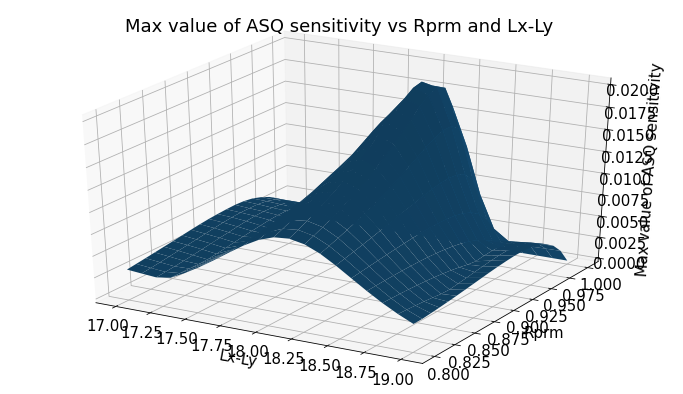

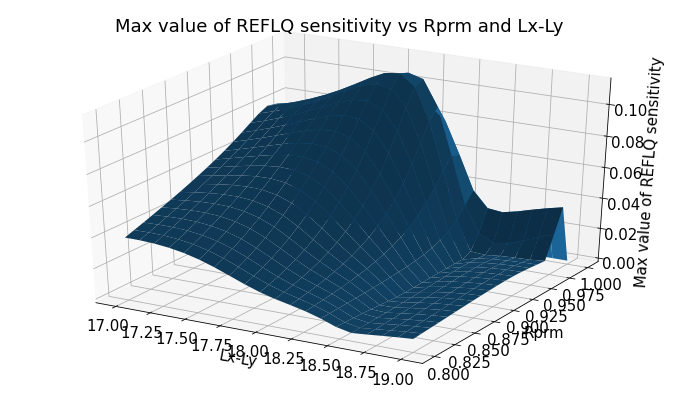

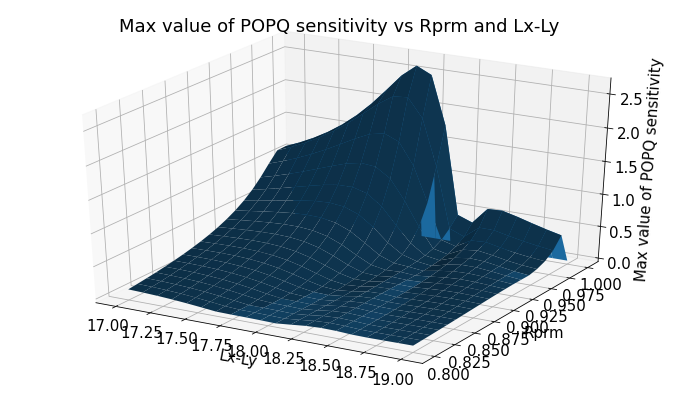

In [12]:
# print(pykat.lastErrorKat)

incode= """
l i1 1 0 n0
mod eo1 9000k .18 1 pm n0 n1 

s s1 1 n1 n4

m PRM 0 1 0 n4 n5 # chosen arbitrarily will optimize it 
s lp 1 n5 n6
bs mainbs 0.5 0.5 0 45 n6  n7 n10 n13
s ly 1 n7 n8 
m1 ETMY 5e-06 3.75e-05 0 n8 n9
s lx 1 n10 n11
m1 ETMX 5e-06 3.75e-05 0 n11 n12
s ls 1 n13 n14


#xaxis lx L lin 0 2.128e-6 1000
xaxis ETMX phi lin 0 360 359

# pd0 PIn n4*
# pd0 AfterPRM n5
# pd0 InBS n6*
# pd0 Outy n7
# pd0 Outx n10

# pd0 iny n7*
# pd0 inx n10*
# pd0 ASDC n14

# pd0 Out n14
# pd0 REFLDC n4
# pd0 LeakX n9
# pd0 LeakY n12
#pd1 REFLI 9000k 0 n4
#pd1 REFLQ 9000k 90 n4
#pd1 ASQ 9000k 90 n14
#pd1 ASI 9000k 90 n14
#pd0 IatPRM n5*
#pd0 IatPRM n5*
#pd1 inphase 9000k 0 n1*
#pd1 quadrature 9000k 90 n1*
yaxis abs
"""

from mpl_toolkits.mplot3d import Axes3D
import pykat

import matplotlib.pyplot as plt
# %matplotlib inline
# %matplotlib notebook
import numpy as np 
# from numpy import arange
HH=12
WW=7
plt.rcParams.update({'font.size': 15})

ob = pykat.finesse.kat()
ob.verbose = False
ob.parse(incode)
ob.parse("""pd1 ASQ 9000k 90 n14
pd1 ASI 9000k 0 n14
pd1 POPI 9000k 0 n5*
pd1 POPQ 9000k 90 n5*
pd1 REFLI 9000k 0 n4
pd1 REFLQ 9000k 90 n4
""")

# ob.ly.L=1
# ob.lx.L=1
n=20
dlmin=17
dlmax=19
rmin=0.8
rmax=1
dl=np.zeros(n)
ref=np.linspace(rmin,rmax,n)
dl=np.linspace(dlmin,dlmax,n)

REFLECTIVITY, DL = np.meshgrid(ref,dl)

ob.lp.L=14.81

Maxasq=np.zeros((n,n))
Maxreflq=np.zeros((n,n))
Maxpopq=np.zeros((n,n))
for j in range(n):
    r=rmin+(j*((rmax-rmin)/(n-1)))
    ob.PRM.R=r
    ob.PRM.T=1-r
#     print(r)

    for i in range(n):
        dli=dlmin+(i*((dlmax-dlmin)/(n-1)))
        
        ob.lx.L=dli+1
    #     print(ob.lx.L)
        res=ob.run()
        
        Maxasq[i][j]=max(np.diff(res["ASQ"]))
        Maxreflq[i][j]=max(np.diff(res["REFLQ"]))
        Maxpopq[i][j]=max(np.diff(res["POPQ"]))
    
# print(len(dl))
# print(len(Maxasq))
# print(dl)

popqm=np.amax(Maxpopq)

imax,jmax=np.where(Maxpopq==popqm)

print("Max sensitivity=",popqm, "at Lx-ly=",dlmin+(imax*((dlmax-dlmin)/(n-1))) ,"Rprm=", rmin+(jmax*((rmax-rmin)/(n-1))))
fig = plt.figure()
ax = fig.gca(projection='3d')
plt.title('Max value of ASQ sensitivity vs Rprm and Lx-Ly ')
surf = ax.plot_surface(DL,REFLECTIVITY,Maxasq)
ax.set_xlabel('Lx-Ly')
ax.set_ylabel('Rprm')
ax.set_zlabel('Max value of ASQ sensitivity')
# plt.rcParams['figure.figsize'] = [HH,WW]
plt.show()

fig = plt.figure()
ax = fig.gca(projection='3d')
plt.title('Max value of REFLQ sensitivity vs Rprm and Lx-Ly ')
surf = ax.plot_surface(DL,REFLECTIVITY,Maxreflq)
ax.set_xlabel('Lx-Ly')
ax.set_ylabel('Rprm')
ax.set_zlabel('Max value of REFLQ sensitivity ')
plt.rcParams['figure.figsize'] = [HH,WW]
plt.show()


fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(DL,REFLECTIVITY,Maxpopq)
plt.title('Max value of POPQ sensitivity vs Rprm and Lx-Ly ')
ax.set_xlabel('Lx-Ly')
ax.set_ylabel('Rprm')
ax.set_zlabel('Max value of POPQ sensitivity')
plt.rcParams['figure.figsize'] = [HH,WW]
plt.show()


## Choosing the operating Point 

Max sensitivity is around 2.67 and occurs at Lx-ly= 17.94, Lp=14.81  and  Rprm= 0.9894. So choosing this point as operating point.